# PI-ICR analysis

Created on 17 July 2019 for the ISOLTRAP experiment

@author: Jonas Karthein<br>
@contact: jonas.karthein@cern.ch<br>
@license: MIT license

### References
[1]: https://doi.org/10.1007/s00340-013-5621-0
[2]: https://doi.org/10.1103/PhysRevLett.110.082501
[3]: https://doi.org/10.1007/s10751-019-1601-z

[1] S. Eliseev, _et al._ Appl. Phys. B (2014) 114: 107.<br>
[2] S. Eliseev, _et al._ Phys. Rev. Lett. 110, 082501 (2013).<br>
[3] J. Karthein, _et al._ Hyperfine Interact (2019) 240: 61.<br>


### Introduction

The following code was written to reconstruct raw PI-ICR data, to fit PI-ICR position information and calculate a frequency using the patter 1/2 scheme described in Ref. [1] and to determine a frequency ratio between a measurement ion and a reference ion. Additionally, the code allows to analyze isomeric states separated in pattern 2.

### Required software and libraries

The following code was written in Python 3.7. The required libraries are listed below with a rough description for their task in the code. It doesn't claim to be a full description of the library.
* pandas (data storage and calculation)
* numpy (calculation)
* matplotlib (plotting)
* mle (maximum likelihood estimation)
* scipy (chi square fitting)
* configparser (configuration file processing)
* jupyter (Python notebook environment)

The Python-mle package can be derived from https://github.com/ibab/python-mle, all other packages can be fetched using pip:

In [1]:
!pip3 install pandas numpy matplotlib scipy configparser jupyter

Instead of the regular jupyter environment, one can also use Google Colab.

In [2]:
google_colab = False

if google_colab:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        %cd /content/drive/My\ Drive/Colab/pi-icr/
    except:
        %cd ~/cernbox/Documents/Colab/pi-icr/

### Data files

Specify, whether the analysis involves one or two states separated in pattern 2 by commenting out the not applicable case in lines 10 or 11. Then enter the file paths for all your data files without the `*.txt` extension. In the following, `ioi` represents the Ion of interest, and `ref` the reference ion.

In [3]:
%config InlineBackend.figure_format ='retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle, os

# analysis = {'ioi_g': {},'ref': {}}
analysis = {'ioi_g': {},'ioi_m': {},'ref': {}}

files_ioi_g = ['data/ioi_ground/101In_c_000',
                    'data/ioi_ground/101In_003']
files_ioi_m = ['data/ioi_isomer/101In_c_000',
                    'data/ioi_isomer/101In_005']
files_ref = ['data/ref/101SrF_c_000',
             'data/ref/101SrF_001',
             'data/ref/101SrF_004',
             'data/ref/101SrF_006']

latex_ioi_g = '$^{101}$In$^g$'
latex_ioi_m = '$^{101}$In$^m$'
latex_ref = '$^{101}$SrF'

### Load pre-analyzed data from file or reconstruct raw data

All files are loaded and reconstructed in one big dictionary of dictionaries. It contains besides the positions and timestamps also information about the measurement conditions (excitation frequencies, rounds etc). One can load a whole beamtime at once. Center files must be indicated by a `_c_` in the name (e.g. regular name: `101In_001.txt` $\rightarrow$ center name `101In_c_000.txt`). All the data is at later stages saved in a `pickle` file. This enables quick loading of the data dictionary without the need of re-reconstructing the data.

The reconstruction code is parallelized and can be found in the subfolder `bin/reconstruction.py`

In [4]:
from bin.reconstruction import PIICR
piicr = PIICR()

if os.path.isfile('data/data-save.p'):
    analysis = pickle.load(open('data/data-save.p','rb'))
    print('\nLoading finished!')
else:
    for file in files_ioi_g:
        analysis['ioi_g'].update({file: piicr.prepare(file)})
    if 'ioi_m' in analysis.keys():
        for file in files_ioi_m:
            analysis['ioi_m'].update({file: piicr.prepare(file)})
    for file in files_ref:
        analysis['ref'].update({file: piicr.prepare(file)})
    
    print('\nReconstruction finished!')


Loading finished!


### Individual file selection

The analysis dictionary contains all files. The analysis however is intended to be performed on a file-by-file basis. Please select the individual files here in the variable `file_name`.

In [23]:
# load P1, P2 and C data in panda dataframes for selected file

# file_name = files_ioi_g[1]
# file_name = files_ioi_m[1]
# file_name = files_ref[1]

file_name = files_ioi_g[1]

print('Selected file:',file_name)

if 'ground' in file_name:
    df_p1 = pd.DataFrame(analysis['ioi_g'][file_name]['p1'], columns=['event','x','y','time'])
    df_p2 = pd.DataFrame(analysis['ioi_g'][file_name]['p2'], columns=['event','x','y','time'])
    df_c = pd.DataFrame(analysis['ioi_g'][file_name.split('_0', 1)[0]+'_c_000']['c'],
                        columns=['event','x','y','time'])
elif 'isomer' in file_name:
    df_p1 = pd.DataFrame(analysis['ioi_m'][file_name]['p1'], columns=['event','x','y','time'])
    df_p2 = pd.DataFrame(analysis['ioi_m'][file_name]['p2'], columns=['event','x','y','time'])
    df_c = pd.DataFrame(analysis['ioi_m'][file_name.split('_0', 1)[0]+'_c_000']['c'],
                        columns=['event','x','y','time'])
else:
    df_p1 = pd.DataFrame(analysis['ref'][file_name]['p1'], columns=['event','x','y','time'])
    df_p2 = pd.DataFrame(analysis['ref'][file_name]['p2'], columns=['event','x','y','time'])
    df_c = pd.DataFrame(analysis['ref'][file_name.split('_0', 1)[0]+'_c_000']['c'],
                        columns=['event','x','y','time'])

Selected file: data/ioi_ground/101In_003


### Manual space and time cut

Please perform a rough manual space cut for each file to improve results on the automatic space cutting tool. This is necessary if one deals with two states in pattern two or if there is a lot of background. This selection will be ellipsoidal. Additionally, please perform a rough time of flight (ToF) cut.

In [24]:
# manual_space_cut = [x_peak_pos, x_peak_spread, y_peak_pos, y_peak_spread]
manual_space_cut = {'data/ioi_ground/101In_003': [130, 150, 220, 150],
              'data/ioi_isomer/101In_005': [155, 150, 230, 150],
              'data/ref/101SrF_001': [-220, 150, 160, 150],
              'data/ref/101SrF_004': [-220, 150, 160, 150],
              'data/ref/101SrF_006': [-220, 150, 160, 150]}

# manual_tof_cut = [tof_min, tof_max]
manual_tof_cut = [20, 50]

# manual_z_cut <= number of ions in the trap
manual_z_cut = 5

### Automatic time and space cuts based on Gaussian distribution

This section contains all cuts in time and space in different steps. 
1. In the time domain contaminants are removed by fitting a gaussian peak to the largest peak in the ToF spectrum and cutting +/- 5 $\sigma$ (change cut range in lines 70 & 71). The ToF distribution has to be binned first before the maximum can be found.
2. Manual space cut is applied for pattern 1 and pattern 2 (not for the center spot)
3. Outlyers/wrongly excited ions are removed +/- 3 $\sigma$ by measures of a simple mean in x and y after applying the manual cut (change cut range in lines).
4. Ejections with more than `manual_z_cut` number of ions in the trap (without taking into account the detector efficiency) are rejected (= z-class cut)

Optimization terminated successfully.
         Current function value: 7.664689
         Iterations: 8
         Function evaluations: 17
         Gradient evaluations: 13

p1: data size: 80 -> time cut: 79 -> manual space cut: 78 -> automatic space cut: 75 -> z-class-cut: 75

Optimization terminated successfully.
         Current function value: 17.535211
         Iterations: 6
         Function evaluations: 11
         Gradient evaluations: 11

p2: data size: 84 -> time cut: 84 -> manual space cut: 80 -> automatic space cut: 74 -> z-class-cut: 74

Optimization terminated successfully.
         Current function value: 0.924665
         Iterations: 10
         Function evaluations: 19
         Gradient evaluations: 16

c: data size: 151 -> time cut: 150 -> manual space cut: 150 -> automatic space cut: 146 -> z-class-cut: 146



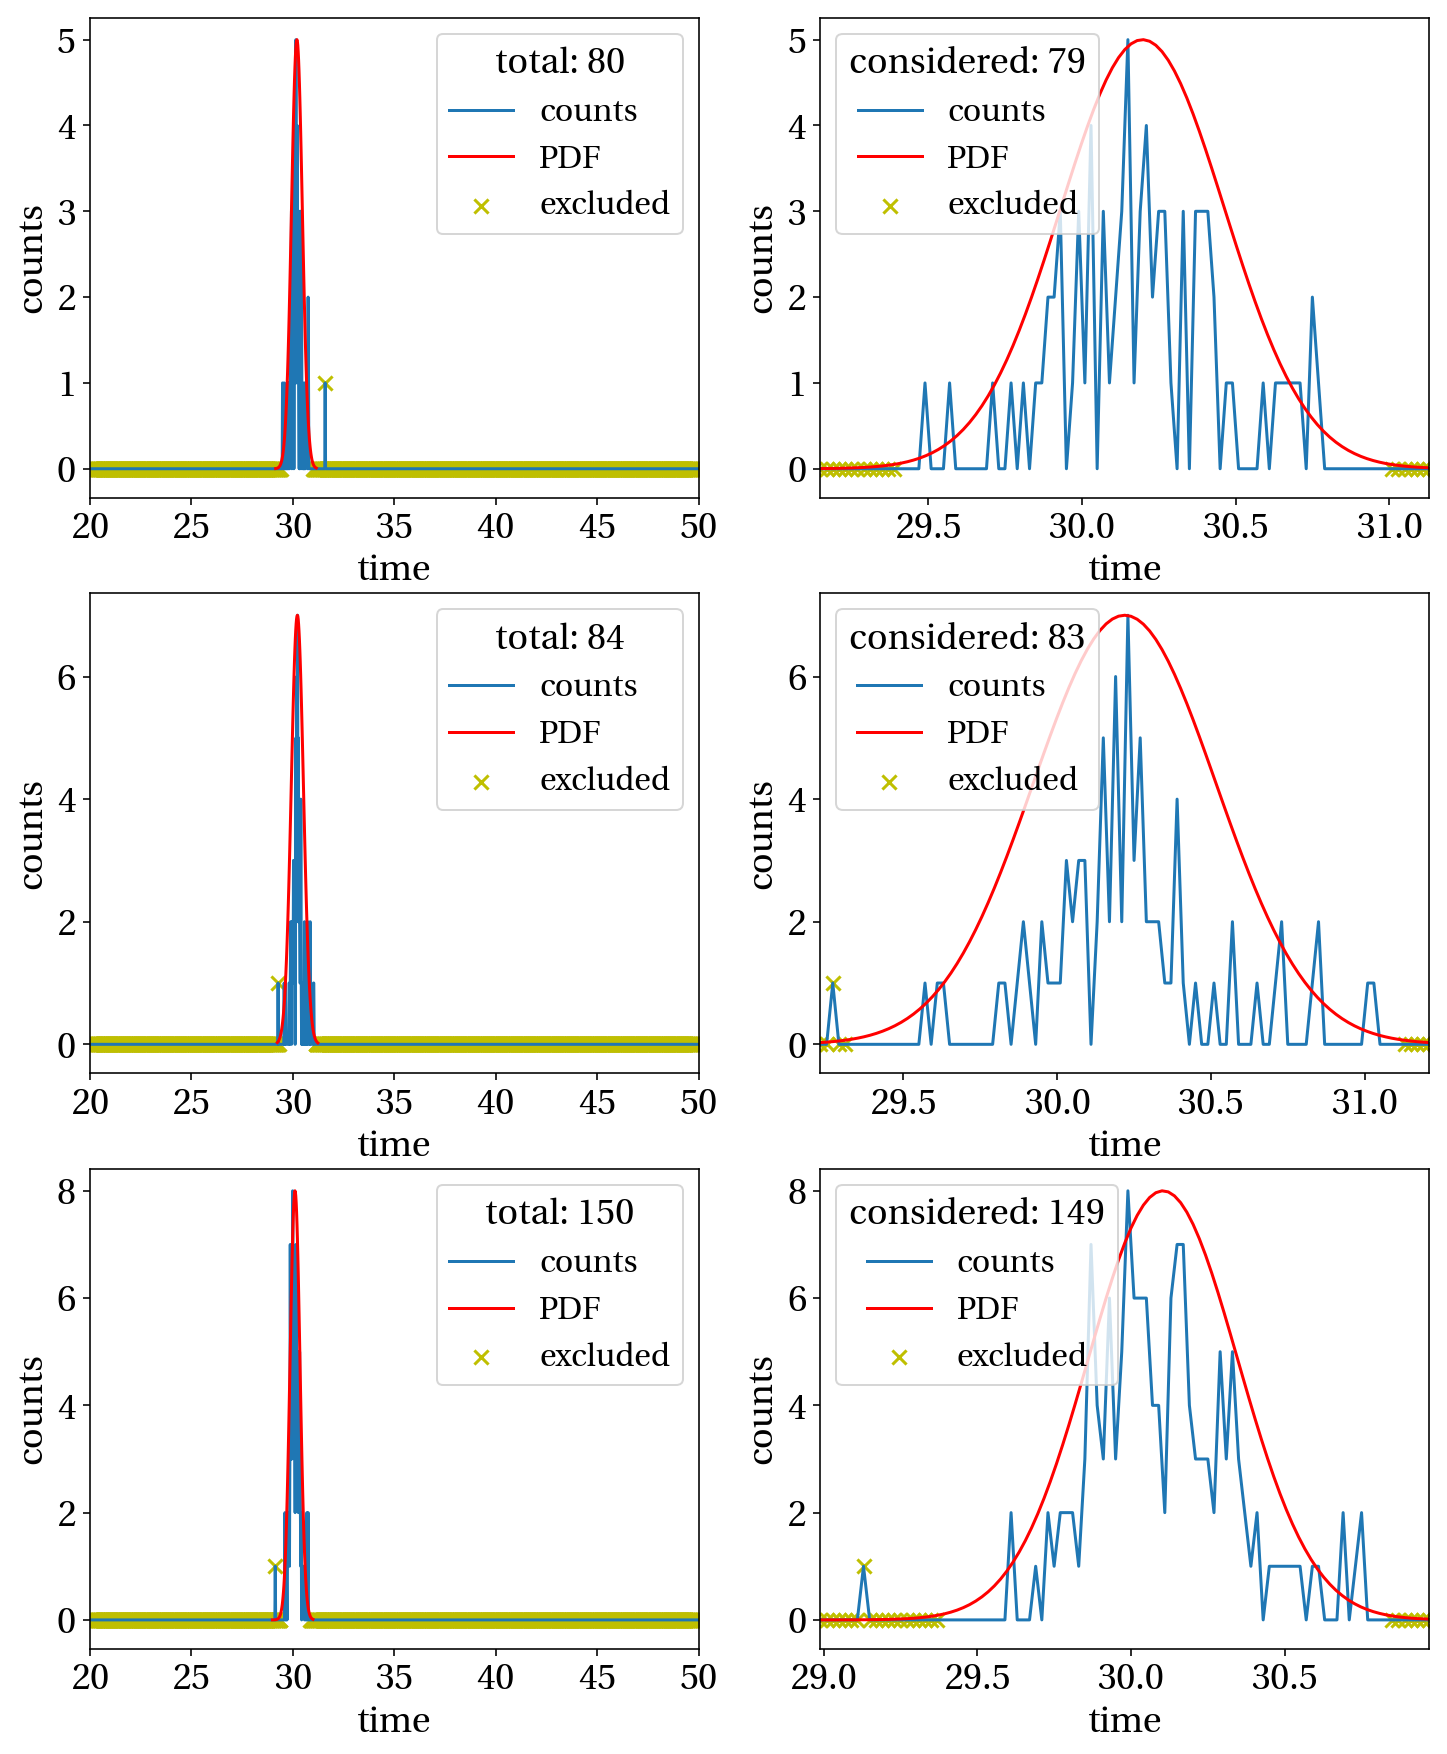

In [25]:
%config InlineBackend.figure_format ='retina'

import matplotlib as mpl
import matplotlib
import mle
import scipy
mpl.rc('font', family='serif', serif='Utopia')      # Utopia LaTeX font!!
mpl.rc('text', usetex=False)
matplotlib.rcParams.update({'font.size': 18})

df_list = [df_p1, df_p2, df_c]
pattern = ['p1', 'p2', 'c']
bin_time_df = [0,0,0]   # [p1,p2,c] list of dataframes containing the time-binned data
result_t = [0,0,0]      # [p1,p2,c] list of MLE fit result dicts
cut_df = [0,0,0]        # [p1,p2,c] list of dataframes containing the time- and space-cut data
excludes_df = [0,0,0]   # [p1,p2,c] list of dataframes containing the time- and space-cut excluded data
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15))

for df_nr in range(len(df_list)):
    
    
    ##############################
    ### BINNING, FITTING TOF DISTR
    ##############################
    
    
    bin_time_df[df_nr] = pd.DataFrame(pd.value_counts(pd.cut(df_list[df_nr].time, bins=np.arange(manual_tof_cut[0], manual_tof_cut[1],0.02))).sort_index()).rename(index=str, columns={'time': 'counts'}).reset_index(drop=True)
    bin_time_df[df_nr]['time'] = np.arange(manual_tof_cut[0]+0.01,manual_tof_cut[1]-0.01,0.02)

    # fit gaussian to time distribution using unbinned maximum likelihood estimation (see python mle)
    t = mle.var('x', observed=True, vector=True)
    mean_t = mle.var('mean_t')
    sigma_t = mle.var('sigma_t')
    model = mle.Normal(t, mean_t, sigma_t)
    # fit only for reduced dataframe, cut around the maximum of the binned distribution
    result_t[df_nr] = model.fit({'x': df_list[df_nr][(df_list[df_nr].time > bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()] - 1.0) &
                                              (df_list[df_nr].time < bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()] + 1.0)].time.to_numpy()},
                         {'mean_t': bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()],
                          'sigma_t': 0.3})


    ##############################
    ### VISUALIZE TOF DISTRIBUTION   # kind='bar' is VERY time consuming -> use kind='line' instead!
    ##############################
    
    
    # whole distribution
    bin_time_df[df_nr].plot(x='time', y='counts', kind='line', xticks=np.arange(manual_tof_cut[0],manual_tof_cut[1]+1,5), ax=axes[df_nr,0])

    # reduced peak plus fit
    bin_time_df[df_nr][bin_time_df[df_nr].counts.idxmax()-50:bin_time_df[df_nr].counts.idxmax()+50].plot(x='time', y='counts', kind='line', ax=axes[df_nr,1])
    pdf_x = np.arange(bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()-50],
                      bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()+51],
                      (bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()+51]
                       -bin_time_df[df_nr].time[bin_time_df[df_nr].counts.idxmax()-50])/100)
    pdf_y = scipy.stats.norm.pdf(pdf_x, result_t[df_nr]['x']['mean_t'], result_t[df_nr]['x']['sigma_t'])
    axes[df_nr,0].plot(pdf_x, pdf_y/pdf_y.max()*bin_time_df[df_nr].counts.max(), 'r', label='PDF')
    axes[df_nr,1].plot(pdf_x, pdf_y/pdf_y.max()*bin_time_df[df_nr].counts.max(), 'r', label='PDF')

    # mark events in t that will be cut away (+/- 3 sigma = 99.73% of data)
    bin_time_df[df_nr][(bin_time_df[df_nr].time < result_t[df_nr]['x']['mean_t'] - 3*result_t[df_nr]['x']['sigma_t']) |
                (bin_time_df[df_nr].time > result_t[df_nr]['x']['mean_t'] + 3*result_t[df_nr]['x']['sigma_t'])].plot(x='time', y='counts', kind='scatter', ax=axes[df_nr,0], c='y', marker='x', s=50, label='excluded')
    bin_time_df[df_nr][(bin_time_df[df_nr].time < result_t[df_nr]['x']['mean_t'] - 3*result_t[df_nr]['x']['sigma_t']) |
                (bin_time_df[df_nr].time > result_t[df_nr]['x']['mean_t'] + 3*result_t[df_nr]['x']['sigma_t'])].plot(x='time', y='counts', kind='scatter', ax=axes[df_nr,1], c='y', marker='x', s=50, label='excluded')
    
    # legend title shows total number of events and reduced number of events
    axes[df_nr,0].legend(title='total: {}'.format(bin_time_df[df_nr].counts.sum()),loc='upper right', fontsize=16)
    axes[df_nr,1].legend(title='considered: {}'.format(bin_time_df[df_nr].counts.sum()-bin_time_df[df_nr][(bin_time_df[df_nr].time < result_t[df_nr]['x']['mean_t'] - 3*result_t[df_nr]['x']['sigma_t']) |
                (bin_time_df[df_nr].time > result_t[df_nr]['x']['mean_t'] + 3*result_t[df_nr]['x']['sigma_t'])].counts.sum()),loc='upper left', fontsize=16)

    
    ##############################
    ### APPYING ALL CUTS
    ##############################
    
    
    # cutting in t: mean +/- 5 sigma
    cut_df[df_nr] = df_list[df_nr][(df_list[df_nr].time > (result_t[df_nr]['x']['mean_t'] - 5*result_t[df_nr]['x']['sigma_t']))&
                (df_list[df_nr].time < (result_t[df_nr]['x']['mean_t'] + 5*result_t[df_nr]['x']['sigma_t']))]
    len1 = cut_df[df_nr].shape[0]
    
    # applying manual cut in x and y:
    if df_nr < 2:  # only for p1 and p2, not for c 
        cut_df[df_nr] = cut_df[df_nr][((cut_df[df_nr].x-manual_space_cut[file_name][0])**2 + (cut_df[df_nr].y-manual_space_cut[file_name][2])**2) <
                        manual_space_cut[file_name][1]*manual_space_cut[file_name][3]]
    len2 = cut_df[df_nr].shape[0]

    # applyig automatic cut in x and y: mean +/- 3 std in an ellipsoidal cut
    cut_df[df_nr] = cut_df[df_nr][((cut_df[df_nr].x-cut_df[df_nr].x.mean())**2 + (cut_df[df_nr].y-cut_df[df_nr].y.mean())**2) <
                    3*cut_df[df_nr].x.std()*3*cut_df[df_nr].y.std()]
    len3 = cut_df[df_nr].shape[0]

    # applying automatic z-class-cut (= cut by number of ions per event) for z>5 ions per event to reduce space-charge effects:
    cut_df[df_nr] = cut_df[df_nr][cut_df[df_nr].event.isin(cut_df[df_nr].event.value_counts()[cut_df[df_nr].event.value_counts() <= 6].index)]
    
    # printing the reduction of the number of ions per file in each of the cut steps
    print('\n{}: data size: {} -> time cut: {} -> manual space cut: {} -> automatic space cut: {} -> z-class-cut: {}\n'.format(pattern[df_nr], df_list[df_nr].shape[0], len1, len2, len3, cut_df[df_nr].shape[0]))

    # saves excluded data (allows visual checking later)
    excludes_df[df_nr] = pd.concat([df_list[df_nr], cut_df[df_nr]]).drop_duplicates(keep=False).reset_index(drop=True)

plt.savefig('{}-tof.pdf'.format(file_name))
plt.show()

### Spot fitting

2D gaussian maximum likelihood estimations of the cleaned pattern 1, pattern 2 and center spot positions are performed using the Python-mle package. Displayed are all uncut data with a blue-transparent point. This allows displaying a density of points by the shade of blue without the need of binning the data (= reducing the information; also: binning is much more time-consuming). The cut data is displayed with a black "x" at the position of the blue point. These points are not considered in the fit (represented by the red (2-$\sigma$ band) and blue (6-$\sigma$ band)) but allow for an additional check of the cutting functions. The scale of the MCP-position plots is given in the time unit of the position-sensitive MCP data. There is no need in converting it into a mm-unit since one is only interested in the angle. 

(75, 4)
Optimization terminated successfully.
         Current function value: 689.481408
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
(74, 4)
Optimization terminated successfully.
         Current function value: 713.034804
         Iterations: 9
         Function evaluations: 10
         Gradient evaluations: 10
(146, 4)
Optimization terminated successfully.
         Current function value: 1382.743620
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5


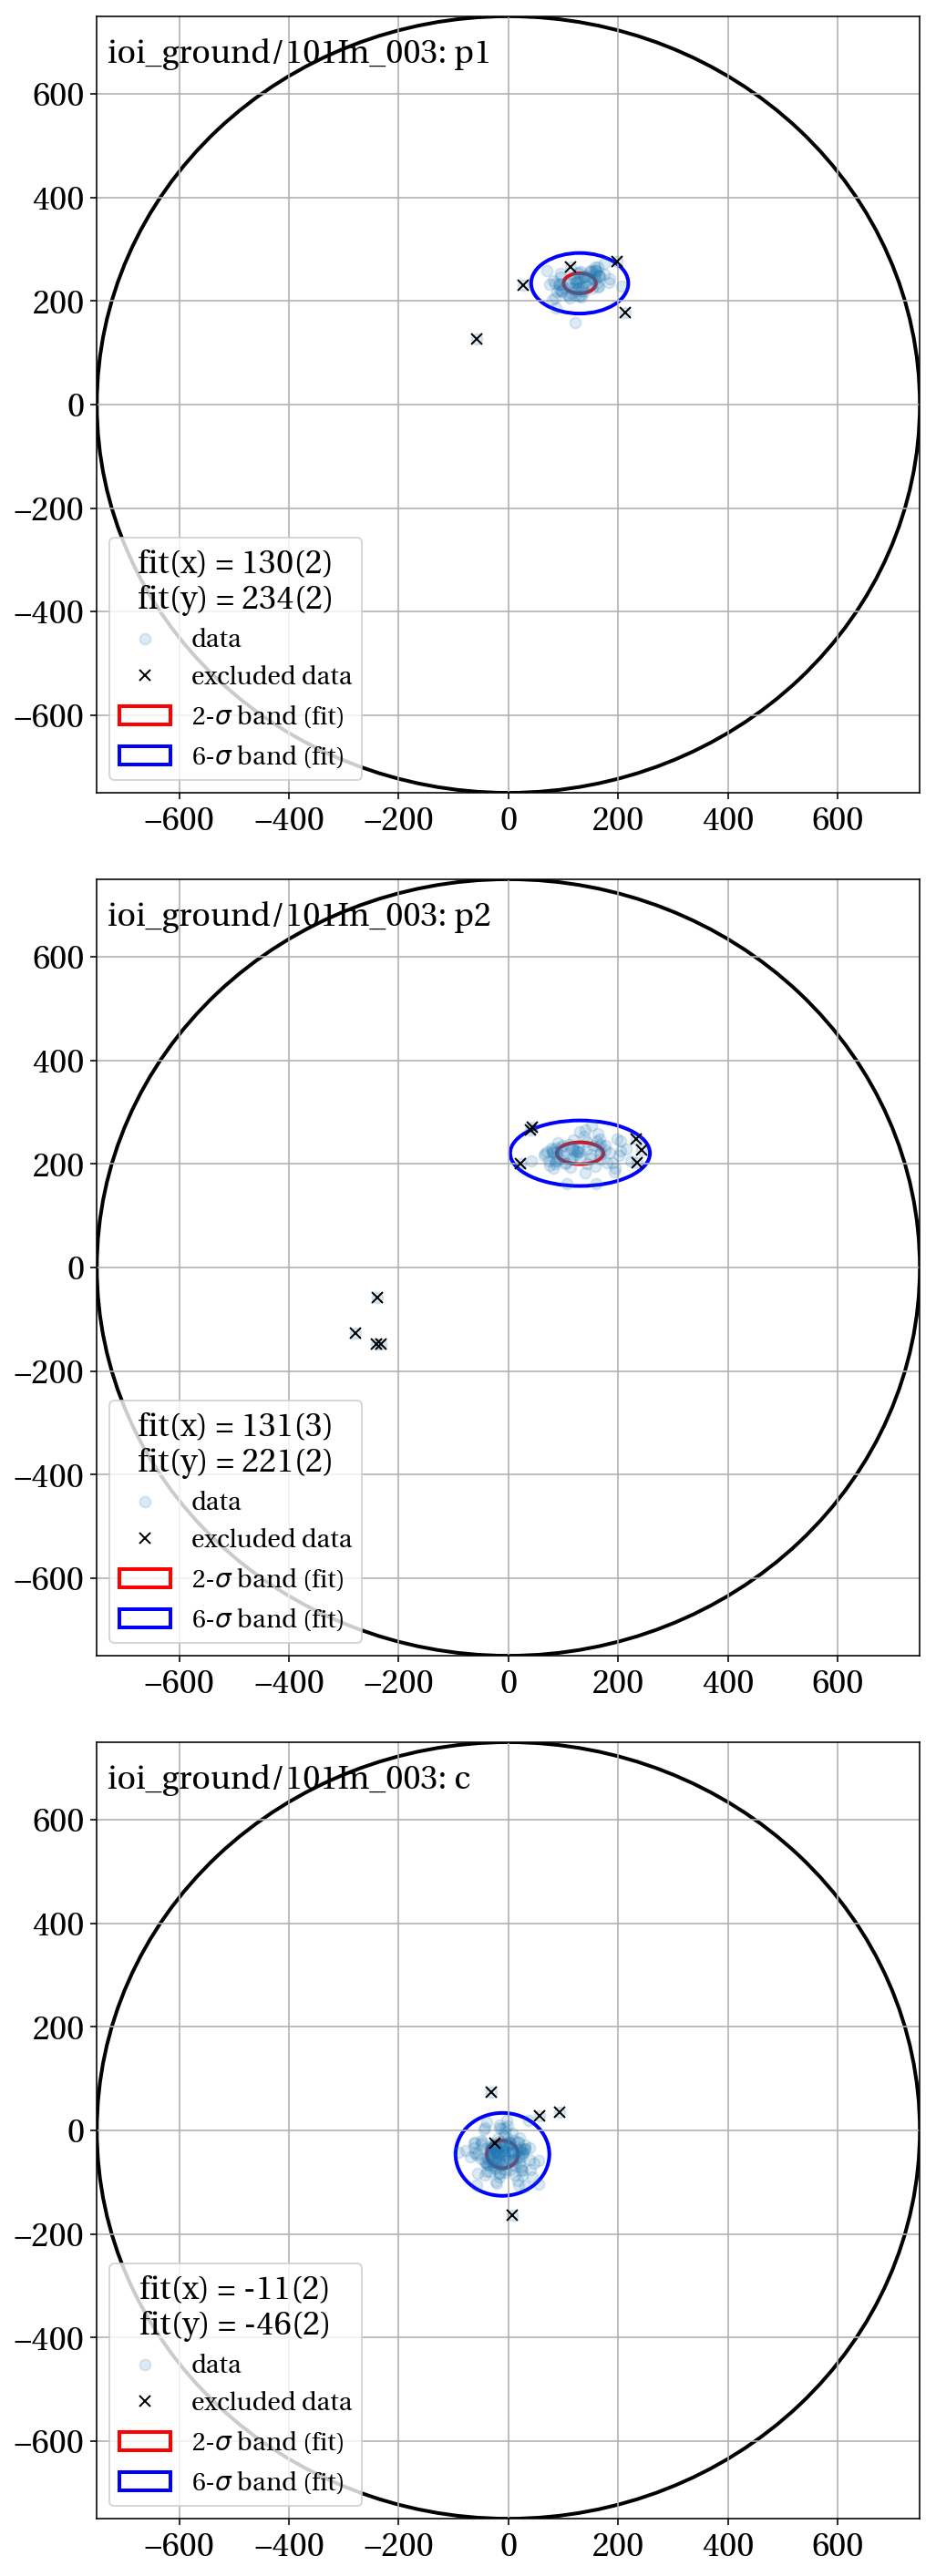

In [26]:
%config InlineBackend.figure_format ='retina'

import matplotlib, mle, pickle, os

# open preanalyzed dataset if existing
if os.path.isfile('data/data-save.p'):
    analysis = pickle.load(open('data/data-save.p','rb'))

df_list = [df_p1, df_p2, df_c]
result = [0,0,0]
fig2, axes2 = plt.subplots(nrows=3, ncols=1, figsize=(7.5, 20))
piicr_scheme_names = ['p1','p2','c']

##############################
### FITTING THE SPOTS IN 2DMLE
##############################


for df_nr in range(len(df_list)):

    print(cut_df[df_nr].shape)
    # define variables
    x = mle.var('x', observed=True, vector=True)
    y = mle.var('y', observed=True, vector=True)

    # define fit parameters
    mean_x = mle.var('mean_x')
    mean_y = mle.var('mean_y')
    sigma_x = mle.var('sigma_x')
    sigma_y = mle.var('sigma_y')

    # define 1D models
    model_x = mle.Normal(x, mean_x, sigma_x)
    model_y = mle.Normal(y, mean_y, sigma_y)

    # merge individual models to a 2D model
    model = mle.Join(model_x, model_y)

    # fit model to data
    result[df_nr] = model.fit({'x': cut_df[df_nr].x.to_numpy(),
                        'y': cut_df[df_nr].y.to_numpy()},
                       {'mean_x': cut_df[df_nr].x.mean(),
                        'mean_y': cut_df[df_nr].y.mean(),
                        'sigma_x': cut_df[df_nr].x.std(),
                        'sigma_y': cut_df[df_nr].y.std()})


    ##############################
    ### VISUALIZE SPOTS & FITS
    ##############################


    if result[df_nr]['success']:
        axes2[df_nr].plot(df_list[df_nr].x.to_numpy(),df_list[df_nr].y.to_numpy(),'o',alpha=0.15, label='data')
        axes2[df_nr].plot(excludes_df[df_nr].x.to_numpy(), excludes_df[df_nr].y.to_numpy(), 'x k',
                          label='excluded data')
        fit_1_sig = mpl.patches.Ellipse((result[df_nr]['x']['mean_x'], result[df_nr]['x']['mean_y']),
                                        2*result[df_nr]['x']['sigma_x'], 2*result[df_nr]['x']['sigma_y'],
                                        edgecolor='r', fc='None', lw=2, label='2-$\sigma$ band (fit)')
        axes2[df_nr].add_patch(fit_1_sig)
        fit_2_sig = mpl.patches.Ellipse((result[df_nr]['x']['mean_x'], result[df_nr]['x']['mean_y']),
                                        3*2*result[df_nr]['x']['sigma_x'], 3*2*result[df_nr]['x']['sigma_y'],
                                        edgecolor='b', fc='None', lw=2, label='6-$\sigma$ band (fit)')
        axes2[df_nr].add_patch(fit_2_sig)
        mcp_circ = matplotlib.patches.Ellipse((0,0), 1500, 1500, edgecolor='k', fc='None', lw=2)
        axes2[df_nr].add_patch(mcp_circ)
        axes2[df_nr].legend(title='fit(x) = {:1.0f}({:1.0f})\nfit(y) = {:1.0f}({:1.0f})'.format(result[df_nr]['x']['mean_x'],np.sqrt(result[df_nr]['hess_inv'][0,0]),
                                                                             result[df_nr]['x']['mean_y'],np.sqrt(result[df_nr]['hess_inv'][2,2])),
                   loc='lower left', fontsize=14)
        axes2[df_nr].axis([-750,750,-750,750])
        axes2[df_nr].grid(True)
        axes2[df_nr].text(-730, 660, '{}: {}'.format(file_name.split('/',1)[-1], piicr_scheme_names[df_nr]))
        plt.tight_layout()
    else:
        print('WARNING: fit did not converge!')
    
    # save fit information
    if 'ground' in file_name:
        analysis['ioi_g'][file_name]['fit-{}'.format(piicr_scheme_names[df_nr])] = result[df_nr]
    elif 'isomer' in file_name:
        analysis['ioi_m'][file_name]['fit-{}'.format(piicr_scheme_names[df_nr])] = result[df_nr]
    else:
        analysis['ref'][file_name]['fit-{}'.format(piicr_scheme_names[df_nr])] = result[df_nr]

plt.savefig('{}-fit.pdf'.format(file_name))
plt.show()

# save all data using pickle
pickle.dump(analysis, open('data/data-save.p','wb'))


---
# !!! <font color='red'>REPEAT</font> CODE ABOVE FOR ALL INDIVIDUAL FILES !!!
---
<br>
<br>

### Save fit data to dataframe and *.csv file

<br>Continue here after analyzing all files individually. The following command saves all necessary data and fit information in a `*.csv` file.

In [27]:
calc_df = pd.DataFrame()
for key in analysis.keys():
    for subkey in analysis[key].keys():
        if '_c_' not in subkey:
            calc_df = calc_df.append(pd.DataFrame({'file': subkey,
                            'p1_x': analysis[key][subkey]['fit-p1']['x']['mean_x'],
                            'p1_y': analysis[key][subkey]['fit-p1']['x']['mean_y'],
                            'p2_x': analysis[key][subkey]['fit-p2']['x']['mean_x'],
                            'p2_y': analysis[key][subkey]['fit-p2']['x']['mean_y'],
                            'c_x': analysis[key][subkey]['fit-c']['x']['mean_x'],
                            'c_y': analysis[key][subkey]['fit-c']['x']['mean_y'],
                            'p1_x_unc': np.sqrt(analysis[key][subkey]['fit-p1']['hess_inv'][0,0]),
                            'p1_y_unc': np.sqrt(analysis[key][subkey]['fit-p1']['hess_inv'][2,2]),
                            'p2_x_unc': np.sqrt(analysis[key][subkey]['fit-p2']['hess_inv'][0,0]),
                            'p2_y_unc': np.sqrt(analysis[key][subkey]['fit-p2']['hess_inv'][2,2]),
                            'c_x_unc': np.sqrt(analysis[key][subkey]['fit-c']['hess_inv'][0,0]),
                            'c_y_unc': np.sqrt(analysis[key][subkey]['fit-c']['hess_inv'][2,2]),
                            'cyc_freq_guess': analysis[key][subkey]['cyc_freq'],
                            'red_cyc_freq': analysis[key][subkey]['red_cyc_freq'],
                            'mag_freq': analysis[key][subkey]['mag_freq'],
                            'cyc_acc_time': analysis[key][subkey]['cyc_acc_time'],
                            'n_acc': analysis[key][subkey]['n_acc'],
                            'time_start': pd.to_datetime('{} {}'.format(analysis[key][subkey]['time-info'][0], analysis[key][subkey]['time-info'][1]), format='%m/%d/%Y %H:%M:%S', errors='ignore'),
                            'time_end': pd.to_datetime('{} {}'.format(analysis[key][subkey]['time-info'][2], analysis[key][subkey]['time-info'][3]), format='%m/%d/%Y %H:%M:%S', errors='ignore')}, index=[0]), ignore_index=True)
calc_df.to_csv('data/analysis-summary.csv')

### Calculate $\nu_c$ from position fits

[1]: https://doi.org/10.1007/s00340-013-5621-0
[2]: https://doi.org/10.1103/PhysRevLett.110.082501
[3]: https://doi.org/10.1007/s10751-019-1601-z

Can be run independently from everything above by loading the `analysis-summary.csv` file!<br> A detailed description of the $\nu_c$ calculation can be found in Ref. [1], [2] and [3].

In [28]:
import pandas as pd
import numpy as np

# load fit-data file, datetime has to be converted
calc_df = pd.read_csv('data/analysis-summary.csv', header=0, index_col=0)

# calculate angle between the P1-vector (P1_x/y - C_x/y) and the P2-vector (P2_x/y - C_x/y)
calc_df['p1p2_angle'] = np.arctan2(calc_df.p1_y - calc_df.c_y, calc_df.p1_x - calc_df.c_x) \
                      - np.arctan2(calc_df.p2_y - calc_df.c_y, calc_df.p2_x - calc_df.c_x)
                      
# calculate the uncertainty on the angle between the P1/P2 vectors
# see https://en.wikipedia.org/wiki/Atan2
calc_df['p1p2_angle_unc'] = np.sqrt(
        ( calc_df.p1_x_unc * (calc_df.c_y - calc_df.p1_y) / ( (calc_df.p1_x - calc_df.c_x)**2 + (calc_df.p1_y - calc_df.c_y)**2 ) )**2
      + ( calc_df.p1_y_unc * (calc_df.p1_x - calc_df.c_x) / ( (calc_df.p1_x - calc_df.c_x)**2 + (calc_df.p1_y - calc_df.c_y)**2 ) )**2
      + ( calc_df.p2_x_unc * (calc_df.c_y - calc_df.p2_y) / ( (calc_df.p2_x - calc_df.c_x)**2 + (calc_df.p2_y - calc_df.c_y)**2 ) )**2
      + ( calc_df.p2_y_unc * (calc_df.p2_x - calc_df.c_x) / ( (calc_df.p2_x - calc_df.c_x)**2 + (calc_df.p2_y - calc_df.c_y)**2 ) )**2
      + ( calc_df.c_x_unc *
          ( -(calc_df.c_y - calc_df.p1_y) / ( (calc_df.p1_x - calc_df.c_x)**2 + (calc_df.p1_y - calc_df.c_y)**2 ) 
            -(calc_df.c_y - calc_df.p2_y) / ( (calc_df.p2_x - calc_df.c_x)**2 + (calc_df.p2_y - calc_df.c_y)**2 ) ) )**2
      + ( calc_df.c_y_unc *
          ( (calc_df.p1_x - calc_df.c_x) / ( (calc_df.p1_x - calc_df.c_x)**2 + (calc_df.p1_y - calc_df.c_y)**2 ) 
           +(calc_df.p2_x - calc_df.c_x) / ( (calc_df.p2_x - calc_df.c_x)**2 + (calc_df.p2_y - calc_df.c_y)**2 ) ) )**2 )

# calculate cyc freq: total phase devided by total time
calc_df['cyc_freq'] = (calc_df.p1p2_angle + 2*np.pi * calc_df.n_acc) / (2*np.pi * calc_df.cyc_acc_time * 0.000001)
calc_df['cyc_freq_unc'] = calc_df.p1p2_angle_unc / (2*np.pi * calc_df.cyc_acc_time * 0.000001)

calc_df.to_csv('data/analysis-summary.csv')

### Frequency-ratio calculation

[1]: https://doi.org/10.1007/s00340-013-5621-0
[2]: https://doi.org/10.1103/PhysRevLett.110.082501
[3]: https://doi.org/10.1007/s10751-019-1601-z

In order to determine the frequency ratio between the ioi and the ref, simultaneous fits of all for the data set possible polynomial degrees are performed. The code calculates the reduced $\chi^2_{red}$ for each fit and returns only the one with a $\chi^2_{red}$ closest to 1. A detailed description of the procedure can be found in Ref. [3].

In [29]:
import pandas as pd
import numpy as np
from bin.freq_ratio import Freq_ratio
freq = Freq_ratio()

# load fit-data file
calc_df = pd.read_csv('data/analysis-summary.csv', header=0, index_col=0)

# save average time of measurement: t_start+(t_end-t_start)/2
calc_df.time_start = pd.to_datetime(calc_df.time_start)
calc_df.time_end = pd.to_datetime(calc_df.time_end)
calc_df['time'] = calc_df.time_start + (calc_df.time_end - calc_df.time_start)/2
calc_df.to_csv('data/analysis-summary.csv')

# convert avg.time to difference in minutes from first measurement -> allows fitting with small number as x value
calc_df['time_delta'] = ((calc_df['time']-calc_df['time'].min())/np.timedelta64(1, 's')/60)

# selecting data for isotopes
df_ioi_g = calc_df[calc_df.file.str.contains('ground')][['time_delta','cyc_freq','cyc_freq_unc','time','file']]
df_ioi_m = calc_df[calc_df.file.str.contains('isomer')][['time_delta','cyc_freq','cyc_freq_unc','time','file']]

# allows to define a subset of reference frequencies for ground and isomer
df_ref_g = calc_df[calc_df.file.str.contains('ref')][['time_delta','cyc_freq','cyc_freq_unc','time','file']]
df_ref_m = calc_df[calc_df.file.str.contains('ref')][['time_delta','cyc_freq','cyc_freq_unc','time','file']]

# simultaneous polynomial fit, see https://doi.org/10.1007/s10751-019-1601-z
fit1, fit2, ratio1, ratio_unc1, chi_sq1 = freq.ratio_sim_fit(['ref', 'ioi_g'],
                                                 df_ref_g.time_delta.tolist(),
                                                 df_ref_g.cyc_freq.tolist(),
                                                 df_ref_g.cyc_freq_unc.tolist(),
                                                 df_ioi_g.time_delta.tolist(),
                                                 df_ioi_g.cyc_freq.tolist(),
                                                 df_ioi_g.cyc_freq_unc.tolist())
if len(df_ioi_m) > 0:
    fit3, fit4, ratio2, ratio_unc2, chi_sq2 = freq.ratio_sim_fit(['ref', 'ioi_m'],
                                                    df_ref_m.time_delta.tolist(),
                                                    df_ref_m.cyc_freq.tolist(),
                                                    df_ref_m.cyc_freq_unc.tolist(),
                                                    df_ioi_m.time_delta.tolist(),
                                                    df_ioi_m.cyc_freq.tolist(),
                                                    df_ioi_m.cyc_freq_unc.tolist())

[1, 902355.7676570631, 1]
[-4.52127101e-04  9.02355767e+05]
Degree:               linear
Ratio fit parameter:  1.0000952512684795 +/- 4.775272108607514e-08
[1, 902355.7676570631, 1]
[-4.52127101e-04  9.02355767e+05]
Degree:               linear
Ratio fit parameter:  1.0001021787915036 +/- 7.358397989847838e-08


### Frequency-ratio plotting

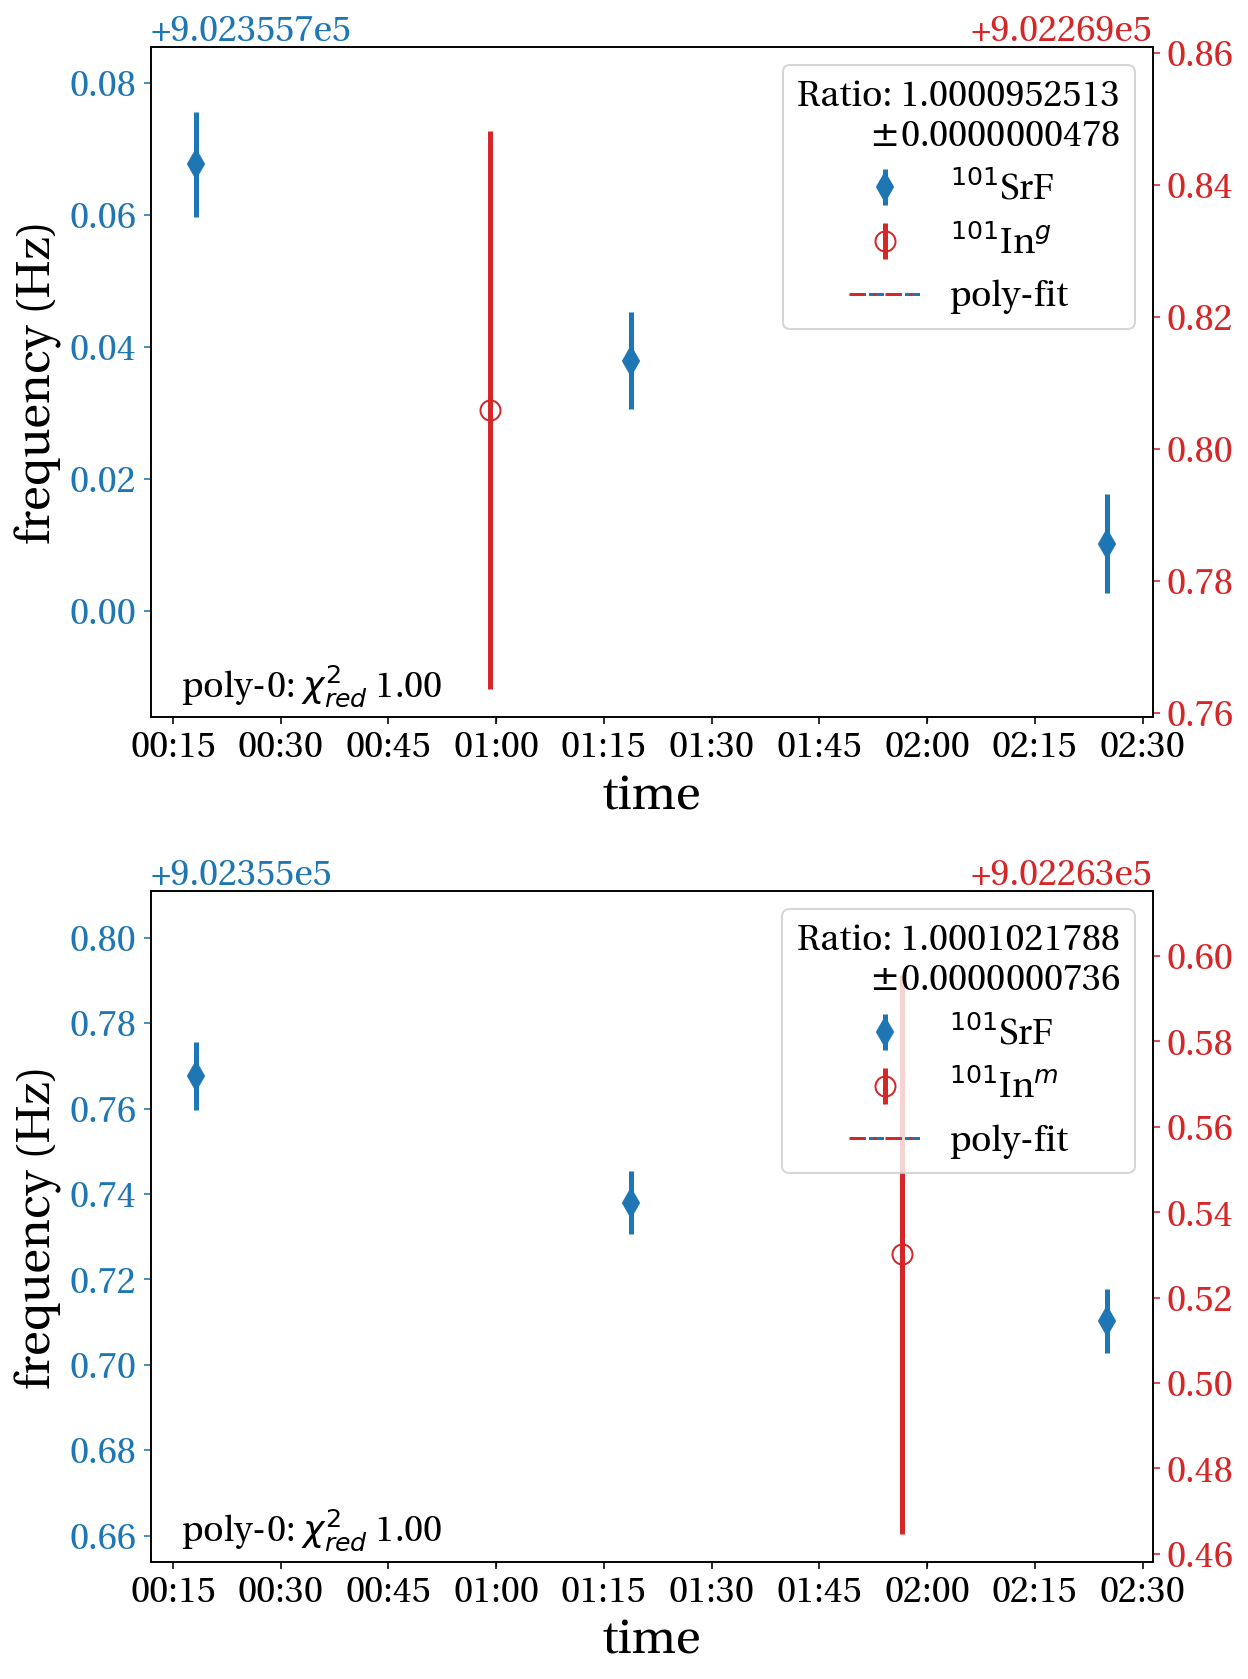

In [30]:
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
mpl.rc('font', family='serif', serif='Utopia')      # Utopia LaTeX font!!
mpl.rc('text', usetex=False)
mpl.rcParams.update({'font.size': 18})

# prepare fit data
x1 = np.linspace(min([df_ioi_g.time_delta.min(),df_ref_g.time_delta.min()]),max([df_ioi_g.time_delta.max(),df_ref_g.time_delta.max()]),500)
t1 = pd.date_range(pd.Series([df_ioi_g.time.min(),df_ref_g.time.min()]).min(),pd.Series([df_ioi_g.time.max(),df_ref_g.time.max()]).max(),periods=500)
if len(df_ioi_m) > 0:
    x2 = np.linspace(min([df_ioi_m.time_delta.min(),df_ref_m.time_delta.min()]),max([df_ioi_m.time_delta.max(),df_ref_m.time_delta.max()]),500)
    t2 = pd.date_range(pd.Series([df_ioi_m.time.min(),df_ref_m.time.min()]).min(),pd.Series([df_ioi_m.time.max(),df_ref_m.time.max()]).max(),periods=500)

fit1_y = [np.polyval(fit1, i) for i in x1]
fit2_y = [np.polyval(fit2, i) for i in x1]
if len(df_ioi_m) > 0:
    fit3_y = [np.polyval(fit3, i) for i in x2]
    fit4_y = [np.polyval(fit4, i) for i in x2]


#########################
### PLOTTING ground state
#########################

if len(df_ioi_m) > 0:
    fig, (ax1, ax3) = plt.subplots(figsize=(9,12),nrows=2, ncols=1)
else:
    fig, ax1 = plt.subplots(figsize=(9,6),nrows=1, ncols=1)

ax1.errorbar(df_ref_g.time, df_ref_g.cyc_freq, yerr=df_ref_g.cyc_freq_unc, fmt='o', label='{}'.format(latex_ref), marker='d', c='#1E77B4', ms=10, elinewidth=2.5)
ax1.set_xlabel('time', fontsize=24, fontweight='bold')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('frequency (Hz)', fontsize=24, fontweight='bold')
ax1.tick_params('y', colors='#1E77B4')
ax1.plot(t1, fit1_y, ls=(5.5, (5, 1, 1, 1, 1, 1, 1, 1)),c='#1E77B4', label='poly-fit')
# Allowing two axes in one subplot
ax2 = ax1.twinx()
ax2.errorbar(df_ioi_g.time, df_ioi_g.cyc_freq, yerr=df_ioi_g.cyc_freq_unc, fmt='o', color='#D62728', label='{}'.format(latex_ioi_g), fillstyle='none', ms=10, elinewidth=2.5) # green: #2ca02c
ax2.tick_params('y', colors='#D62728')
ax2.plot(t1, fit2_y, ls=(0, (5, 3, 1, 3)),c='#D62728', label='poly-fit')

# adjust the y axes to be the same height
middle_y1 = df_ref_g.cyc_freq.min() + (df_ref_g.cyc_freq.max() - df_ref_g.cyc_freq.min())/2
middle_y2 = df_ioi_g.cyc_freq.min() + (df_ioi_g.cyc_freq.max() - df_ioi_g.cyc_freq.min())/2
range_y1 = df_ref_g.cyc_freq.max() - df_ref_g.cyc_freq.min() + 2 * df_ref_g.cyc_freq_unc.max()
range_y2 = df_ioi_g.cyc_freq.max() - df_ioi_g.cyc_freq.min() + 2 * df_ioi_g.cyc_freq_unc.max()
ax1.set_ylim(middle_y1 - 1.3 * max([range_y1, middle_y1*range_y2/middle_y2])/2, middle_y1 + 1.1 * max([range_y1, middle_y1*range_y2/middle_y2])/2)  # outliers only
ax2.set_ylim(middle_y2 - 1.1 * max([middle_y2*range_y1/middle_y1, range_y2])/2, middle_y2 + 1.3 * max([middle_y2*range_y1/middle_y1, range_y2])/2)  # most of the data

# plotting only hours without the date
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
ax2.xaxis.set_minor_locator(mpl.dates.HourLocator())

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles_g = [handles1[1], handles2[1], (handles1[0], handles2[0])]
labels_g = [labels1[1], labels2[1], labels1[0]]
plt.legend(handles=handles_g, labels=labels_g,fontsize=18,title='Ratio: {:1.10f}\n         $\\pm${:1.10f}'.format(ratio1, ratio_unc1), loc='upper right')
plt.text(0.03,0.03,'poly-{}: $\chi^2_{{red}}$ {:3.2f}'.format(len(fit1)-1, chi_sq1),transform=ax1.transAxes)


###########################
### PLOTTING isomeric state
###########################

if len(df_ioi_m) > 0:
    ax3.errorbar(df_ref_m.time, df_ref_m.cyc_freq, yerr=df_ref_m.cyc_freq_unc, fmt='o', label='{}'.format(latex_ref), marker='d', c='#1E77B4', ms=10, elinewidth=2.5)
    ax3.set_xlabel('time', fontsize=24, fontweight='bold')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax3.set_ylabel('frequency (Hz)', fontsize=24, fontweight='bold')
    ax3.tick_params('y', colors='#1E77B4')
    ax3.plot(t2, fit3_y, ls=(5.5, (5, 1, 1, 1, 1, 1, 1, 1)),c='#1E77B4', label='poly-fit')
    # Allowing two axes in one subplot
    ax4 = ax3.twinx()
    ax4.errorbar(df_ioi_m.time, df_ioi_m.cyc_freq, yerr=df_ioi_m.cyc_freq_unc, fmt='o', color='#D62728', label='{}'.format(latex_ioi_m), fillstyle='none', ms=10, elinewidth=2.5) # green: #2ca02c
    ax4.tick_params('y', colors='#D62728')
    ax4.plot(t2, fit4_y, ls=(0, (5, 3, 1, 3)),c='#D62728', label='poly-fit')

    # adjust the y axes to be the same height
    middle_y3 = df_ref_m.cyc_freq.min() + (df_ref_m.cyc_freq.max() - df_ref_m.cyc_freq.min())/2
    middle_y4 = df_ioi_m.cyc_freq.min() + (df_ioi_m.cyc_freq.max() - df_ioi_m.cyc_freq.min())/2
    range_y3 = df_ref_m.cyc_freq.max() - df_ref_m.cyc_freq.min() + 2 * df_ref_m.cyc_freq_unc.max()
    range_y4 = df_ioi_m.cyc_freq.max() - df_ioi_m.cyc_freq.min() + 2 * df_ioi_m.cyc_freq_unc.max()
    ax3.set_ylim(middle_y3 - 1.3 * max([range_y3, middle_y3*range_y4/middle_y4])/2, middle_y3 + 1.1 * max([range_y3, middle_y3*range_y4/middle_y4])/2)  # outliers only
    ax4.set_ylim(middle_y4 - 1.1 * max([middle_y4*range_y3/middle_y3, range_y4])/2, middle_y4 + 1.3 * max([middle_y4*range_y3/middle_y3, range_y4])/2)  # most of the data

    # plotting only hours without the date
    ax4.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax4.xaxis.set_minor_locator(mpl.dates.HourLocator())

    handles3, labels3 = ax3.get_legend_handles_labels()
    handles4, labels4 = ax4.get_legend_handles_labels()
    handles_m = [handles3[1], handles4[1], (handles3[0], handles4[0])]
    labels_m = [labels3[1], labels4[1], labels3[0]]
    plt.legend(handles=handles_m, labels=labels_m, fontsize=18,title='Ratio: {:1.10f}\n         $\\pm${:1.10f}'.format(ratio2, ratio_unc2), loc='upper right')
    plt.text(0.03,0.03,'poly-{}: $\chi^2_{{red}}$ {:3.2f}'.format(len(fit3)-1, chi_sq2),transform=ax3.transAxes)

plt.tight_layout()
plt.savefig('data/101In-ratios.pdf')
plt.show()